In [3]:
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
import segmentation_models as sm
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import os
import keras
from random import randint

from keras.utils import normalize
from keras.metrics import MeanIoU

import tensorflow as tf


In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


Num GPUs Available:  1
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [9]:
SIZE_X = 128
SIZE_Y = 128
n_classes = 4

images_path = "128_patches/images_as_128x128_patches.tif"
masked_path = "128_patches/masks_as_128x128_patches.tif"
train_images = []
train_masked = []

In [10]:
with Image.open(images_path) as img:

    for i in range(img.n_frames):
        img.seek(i)

        img_np = np.array(img)
        rgb_image = np.stack((img_np,)*3, axis=-1)
        train_images.append(rgb_image)


with Image.open(masked_path) as img:


    for i in range(img.n_frames):
        img.seek(i)
        
        img_np = np.array(img)
        train_masked.append(img_np)

In [11]:
train_images = np.array(train_images)
train_masked = np.array(train_masked)

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
n, h, w = train_masked.shape
train_masked_reshaped = train_masked.reshape(-1, 1)
train_masked_reshaped_encoded = label_encoder.fit_transform(train_masked_reshaped)
train_masked_encoded_original_shape = train_masked_reshaped_encoded.reshape(n, h, w)

train_masked_input = np.expand_dims(train_masked_encoded_original_shape, axis=3)

c:\Users\USER\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
from sklearn.model_selection import train_test_split
# split entire dataset to train and testing 
x_train, x_test, y_train, y_test = train_test_split(train_images, train_masked_input, test_size=0.1, random_state=0)

# split training dataset to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=0)

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

test_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [15]:
activation='softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
prep_x_train = preprocess_input1(x_train)
prep_x_val = preprocess_input1(x_val)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

# print(model1.summary())

# history1=model1.fit(prep_x_train, 
#           y_train_cat,
#           batch_size=8, 
#           epochs=50,
#           verbose=1,
#           validation_data=(x_val, y_val_cat))


# model1.save('res34_backbone_50epochs.hdf5')

In [16]:
from keras.models import load_model

model1 = load_model('./res34_backbone_50epochs.hdf5', compile=False)

y_pred=model1.predict(x_test)
print(y_pred)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax)
print(y_pred_argmax.shape)

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

5/5 [==============================] - 6s 75ms/step
[[[[1.85985933e-03 3.10506730e-04 9.97305512e-01 5.24026866e-04]
   [1.58258510e-04 5.95897291e-05 9.99732077e-01 5.01042232e-05]
   [1.76820511e-04 5.64498914e-05 9.99746978e-01 1.97509853e-05]
   ...
   [4.86531062e-04 3.31208750e-04 9.99096632e-01 8.55800754e-05]
   [3.27250484e-04 3.03570676e-04 9.99305367e-01 6.38950587e-05]
   [5.46369003e-03 1.29948398e-02 9.79806662e-01 1.73475803e-03]]

  [[1.62580414e-04 2.50258017e-05 9.99796689e-01 1.57074737e-05]
   [1.12623811e-05 2.80768791e-06 9.99985218e-01 7.41186454e-07]
   [1.12767930e-05 1.32181310e-06 9.99987125e-01 2.06882135e-07]
   ...
   [4.56659945e-05 7.63625758e-06 9.99942064e-01 4.64299819e-06]
   [3.16423757e-05 5.01016666e-06 9.99961019e-01 2.32811158e-06]
   [6.60490885e-04 6.55555283e-04 9.98585463e-01 9.85815132e-05]]

  [[4.39724710e-04 7.28939704e-05 9.99444902e-01 4.24228383e-05]
   [2.83316422e-05 8.42837198e-06 9.99961495e-01 1.80853874e-06]
   [2.94609981e-05 3

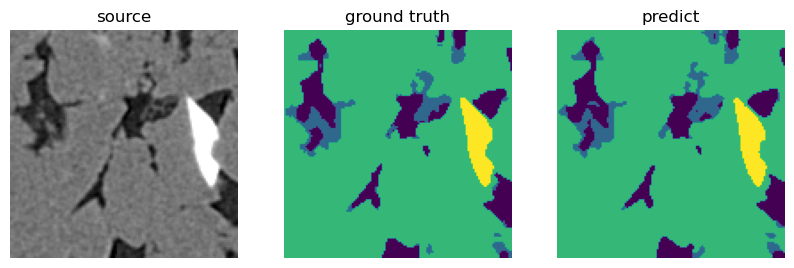

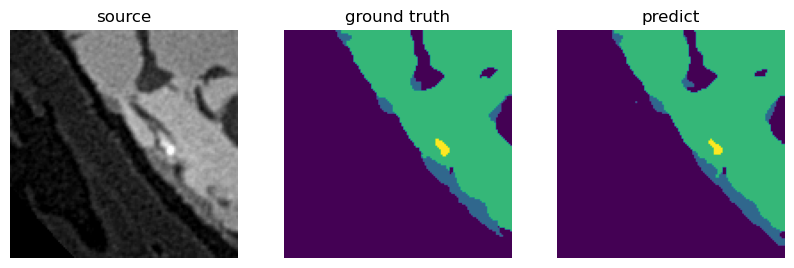

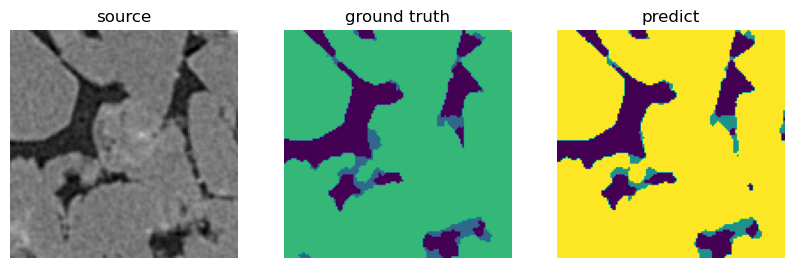

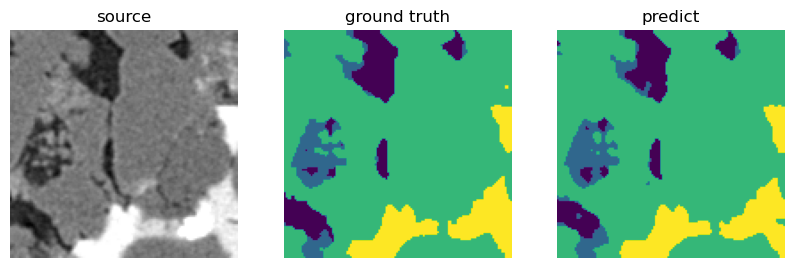

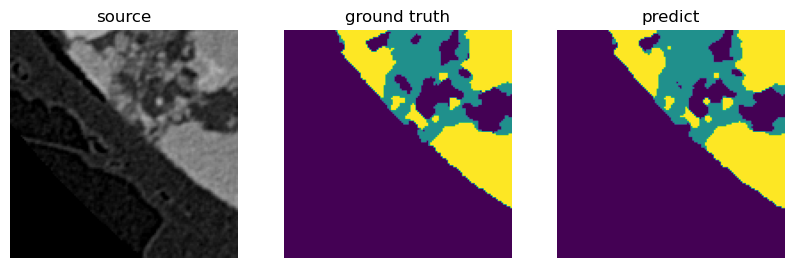

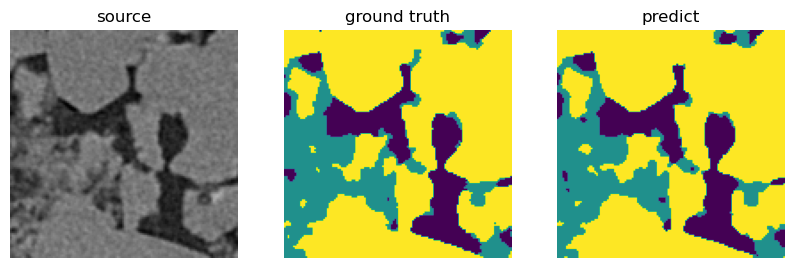

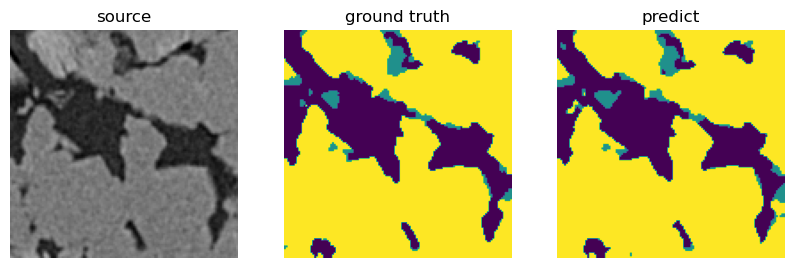

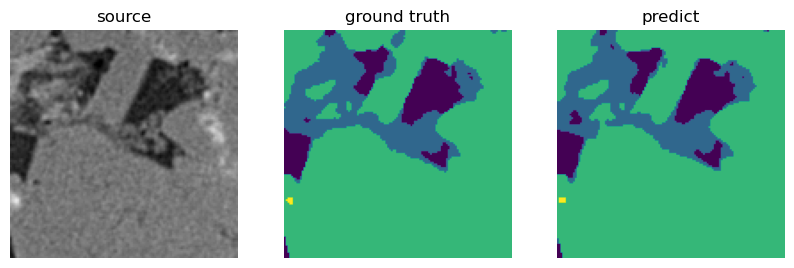

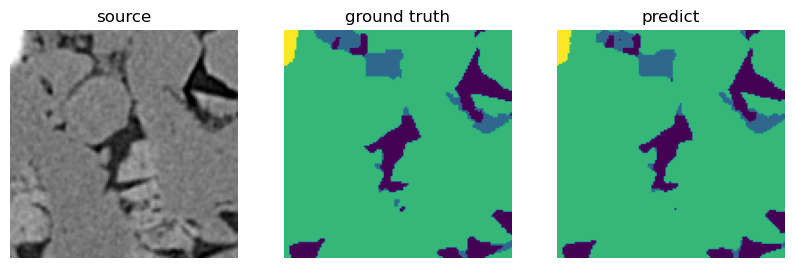

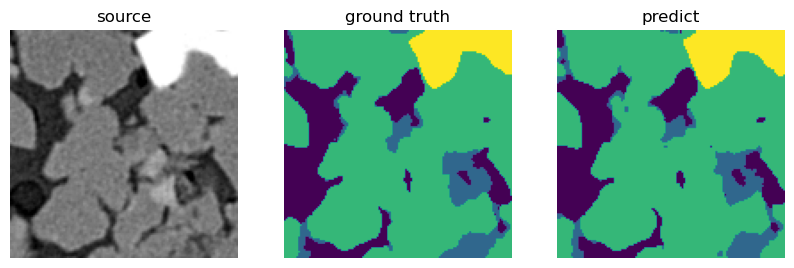

In [18]:
for i in range(10) :
    idx = randint(0, 50)

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(x_test[idx])
    axs[0].set_title("source")
    axs[0].axis('off')

    axs[1].imshow(y_test[idx])
    axs[1].set_title("ground truth")
    axs[1].axis('off')

    axs[2].imshow(y_pred_argmax[idx])
    axs[2].set_title("predict")
    axs[2].axis('off')
